# Fourier Transform

> NOTE: This notebooks takes the notes from official documentation and tutorial of [OpenCV](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html#fourier-transform).

Fourier Transform (FT) is used to understand the frequency characteristics of various filters and images. For digital images specifically, 2D Discrete Fourier Transform (DFT) is used. The DFT is computed using an algorithm called Fast Fourier Transform (FFT).

For a sinusoidal signal denoted by $x(t) = A \sin{(2{\pi}ft)}$ $f$ is the frequency of the signal, and when the frequency domain transformation is taken for this signal, there should be a spike at $f$. An image is a discrete signal, which can also be transformed to frequency domain, but it would have values in the range of $[-{\pi}, {\pi}]$, $[0, 2{\pi}]$, or $[0, N]$ for $N$ points DFT. An image is also a 2D signal ranging in two directions. A DFT can be taken in both direction, and they together gives the frequency domain representation of the image.

For an analog sinusoidal signal if the amplitude of the signal varies too fast in short time (same as saying more oscillating cycles in short time), then it is high frequency signal. If it does not vary that much, then it it is a low frequency signal. A similar thought process works for images. In an image at the edge points, corners, and stripes the pixel intensity (compared to the signal amplitude) vary the most. In case of salt-n-pepper noise we have also seen similar patterns i.e., random spikes in pixel intensities. Hence edges, corners, stripes, and noises are some of the high frequency contents in an image. In most cases an image has both high and low frequency contents.



In this notebook we'd practice these concepts with some image examples. We would use both NumPy and OpenCV utilities. The NumPy package [numpy.fft](https://numpy.org/doc/stable/reference/routines.fft.html) implements the FT utilities. Following are some of the useful functions for using the FT with NumPy.

* `fft.fft2` - It provides frequency transform which will be a complex array. Its first argument is the **grayscale** input image. Second argument is optional, which decides the size of output array. If it is greater than size of input image, input image is padded with zeros before calculation of FFT. If it is less than input image, input image will be cropped. If no arguments passed, Output array size will be same as input.
    > There exists a concept called DC component of a signal, which is relevant in this discussion. The DC component of a signal is the average value / amplitude of a signal over a period of time. Translating the same to our context, it is the average pixel intensity. It is also called the `zero frequency component`, because FT decomposes a signal into sine and cosine components. With respect to the cosine component if we consider the cosine component $\cos{(2{\pi}ft)}$ then for $f = 0$ we'd get $\cos{(2{\pi} * 0 * t)} = 1$. Signal offset is thought in this way. Since this represents the zero frequency it is by default goes to the very left of the frequency domain representation. Similar thing happens for an image. Since input image is 2D spatial domain signal, we make frequency domain transform for both x and y direction. Normally in digital representation of an image (x = 0, y = 0) point is on the top left corner. As a result the zero frequency component representing the average change in intensity goes to the top left corner of the resulting image. In order to shift the zero frequency component to middle of the resulting image we have to shuft it by $\frac{N}2$ in both x and y direction for a square input image of shape $(N, N)$. But for a rectangular image it is problematic. Hence we need an easier option, which we get in form of *fftshift*.
* `fft.fftshift` -  It conveniently shifts the zero frequency component to the middle, as we would see shortly.
    > Once we have found the frequency domain representation, we might want to do some filtering like high pass and then we need to reconstruct the image from frequency domain back to spatial domain. First step of that is to shift the zero frequency component back to its original position, where *ifftshift* comes into play.
* `fft.ifftshift`- It shifts the zero frequency components back to top left corner.
* `fft.ifft2` - It transforms the image from frequency domain back to spatial domain.

Similarly, [OpenCV](https://docs.opencv.org/4.5.5/modules.html) offers several functionalities for working with Discrete Fourier Transform. The above concepts discussed for NumPY function are applicable for OpenCV in the same manner. Following are some of the utilities, which are used in this exercises.

* [cv2.dft](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gadd6cf9baf2b8b704a11b5f04aaf4f39d) - It computes forward or inverse discrete fourier transform on 1D or 2D vector / arrays.
* [cv2.idft](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gaa708aa2d2e57a508f968eb0f69aa5ff1) - It computes the inverse discrete fourier transform on 1D / 2D vector  arrays.
* [cv2.magnitude](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga6d3b097586bca4409873d64a90fe64c3) - It computes the magnitude of 2D vectors.

In [228]:
from typing import Tuple
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

We start with a basic example of a signal to understand, what exactly Fourier Transform does.

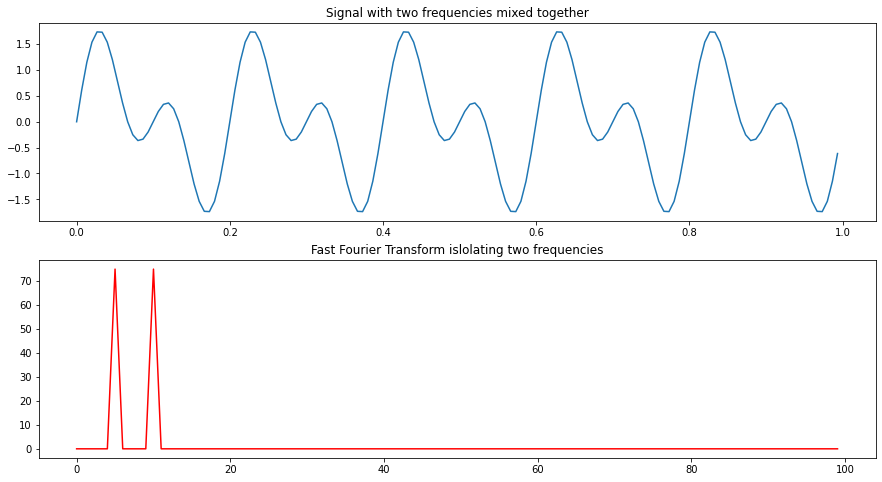

In [229]:
sampling_frequency: float = 150.0
sampling_interval: float = 1.0 / sampling_frequency
time_intervals: np.ndarray = np.arange(0, 1, sampling_interval)

freq1: int = 5
freq2: int = 10

signal: np.ndarray = np.sin(2*np.pi*freq1*time_intervals) + np.sin(2*np.pi*freq2*time_intervals)
sig_ft: np.ndarray = np.fft.fft(signal)

fig, (axs1, axs2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs1.plot(time_intervals, signal)
axs1.set_title('Signal with two frequencies mixed together')
axs2.plot(np.arange(0, 100, 1), np.abs(sig_ft)[:100], 'r')
axs2.set_title('Fast Fourier Transform islolating two frequencies');

First plot shows a signal, where we have mixed two frequencies, 5 Hz and 10 Hz without any phase shift. Then we have taken the FT using the `np.fft` module. We have visualized first 100 components of the FT in the second plot, which clearly isolates the two frequencies, which we have used to create the above signal. In this notebook we apply a similar method to images as spatial signals. We are going to explore some examples of edge detection and noise reduction in images using FT. In the process we'd learn a bit about the filters first.

## Filters

Filters in this context, are similar to the masks, which we used in the exercises of the color thresholds. They are of the same size with input images. We superimpose them to the original image to extract the features and attributes of our interest. We have mentioned above the utility of the `np.fft.fftshift`, which shifts the zero and low frequency components of the image towards the center. We are going to see shortly, that this is extremely useful for creating the filters. When the low frequency regions are shifted towards the center of the image, then we can select specific areas of the image and manipulate e.g., assigning zeros or ones to some areas to isolate the high and low frequencies. In this notebook we would try to make use of the following kinds of filters.

* High-Pass Filter (Only allow high frequency components)
* Low-Pass Filter (Only allow low frequency components)
* Band-Pass Filter (Combines the low-pass and high-pass by not throwing away either of the low and high frequencies completely)

In [230]:
# Specify image directory
image_dir: Path = Path().absolute().joinpath('images')

Shape of the image: (1024, 768)


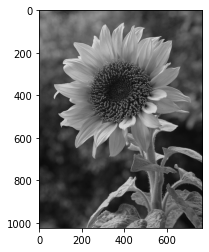

In [231]:
# Import image in grayscale
image: np.ndarray = cv2.imread(filename=image_dir.joinpath('sunflower.jpg').__str__(), flags=cv2.IMREAD_GRAYSCALE)
print(f'Shape of the image: {image.shape}')
plt.imshow(image, cmap='gray');

Shape of the frequency domain transform: (1024, 768, 2)


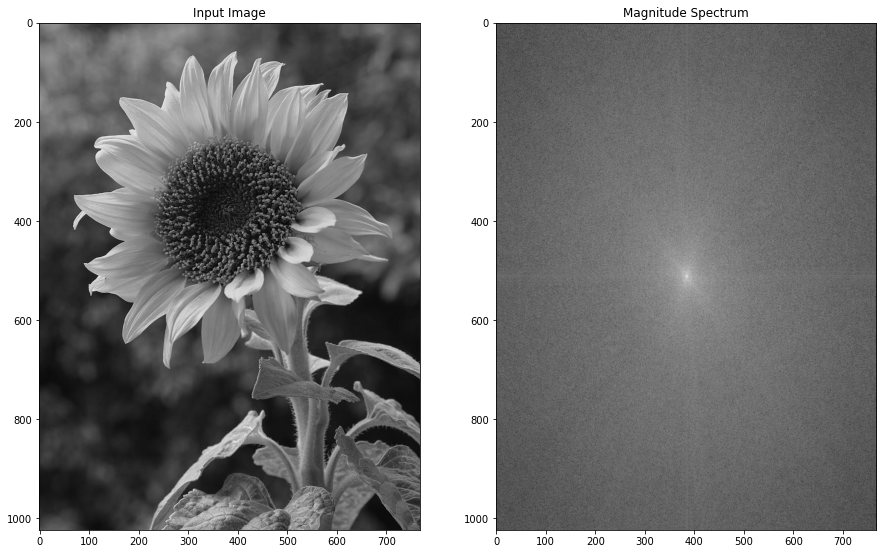

In [232]:
# Convert the image into frequency domain and create magnitude spectrum, which is representation of the frequencies
f: np.ndarray = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
print(f'Shape of the frequency domain transform: {f.shape}')

# Shift the zero frequency component to the center
fshift: np.ndarray = np.fft.fftshift(f)
magnitude_spectrum: np.ndarray = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))

# Plot the input image and magnitude spectrum side by side
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax1.imshow(image, cmap='gray')
ax1.set_title('Input Image')
ax2.imshow(magnitude_spectrum, cmap='gray')
ax2.set_title('Magnitude Spectrum');

There are few key points to notice here.

* The `cv2.dft` function had the input of shape (1024, 768) and it produced an array of shape (1024, 768, 2). The [:, : 0] and [:, :, 1] in this case denote the Fourier Transforms for x and y directions, which we then use in the `cv2.magnitude` function for creating a magnitude spectrum to visualize. One more thing to note here is the use of `logarithm` to generate magnitude spectrum. That is the reason, this spectrum can be called logarithmically scaled magnitude spectrum. Here we are applying log after generating the magnitude of the frequencies (in this case pixel intensities). The advantage of logarithmic scale in this case is, that it shows how the amplitude (pixel intensity) changes for our picture. The disadvantage of using log-magnitude spectrum, is that it is only meaningful in representing the change in amplitude (pixel intensity) but that is enough in our case of image analysis.

* We have used `fftshift` in order to shift the zero frequency components to the middle, and we see more white regions towards the middle as well. White regions denote amplitude or pixel intensity in this case We have to keep in mind, that the magnitude spectrum is a way to reason with the frequency domain representation. It is not the frequency domain representation itself. Magnitude spectrum shows us the different pixel intensities, which make our image. 

In this case by seeing the magnitude spectrum and our original image we see, that there exist some what of a balance between the high and low frequency components in our image. Magnitude spectrum looks somewhat consistent overall.

### High-Pass Filter - Edge Detection

We are going to create a circular high-pass filter from the frequency domain representation of the image. We have already shifted the zero and low frequencies towards the center (zero frequency is at the absolute center). We are going to create a circular mask of zeros i.e., we'd try to block the very low frequencies. In the following examples we used the [np.ogrid](https://numpy.org/doc/stable/reference/generated/numpy.ogrid.html) function to create an open n-dimensional mesh-grid. In our case this is a mesh-grid, which is not formed yet. It returns the x-dimension indices and y-dimension indices separately. For instance since we have 240 rows and 300 columns, we'd get two separate indices arrays of shape (240, 1) as x-dimensional indices and (1, 300) as y-dimensional indices.

In [233]:
# Prepare to create the high-pass filter mask
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2
mask: np.ndarray = np.ones((rows, cols, 2), np.uint8)
radius: int = 80  # Circular mask radius
center: Tuple[int, int] = (crow, ccol)
x, y = np.ogrid[:rows, :cols]

# Select the area of interest i.e., the zero to low frequency region indices in the mask
mask_area: np.ndarray = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius ** 2
mask[mask_area] = 0

# Apply the mask to the frequency domain representation
masked_fshift: np.ndarray = fshift * mask

Here's what we did with the above statements. In a nutshell, we created a high-pass filter mask and applied to the frequency domain representation of the image.

* Firstly, we selected the center points of the image using integer division. That's ok because the image and its DFT are of the same shape. We created an initial array of 1s with the image shape and decided that our mask radius would be 80. We also used the `np.ogrid` to create an open mesh-grid. We got back two arrays of shape (rows, 1), (1, cols). This would in turn be used to select the indices representing a circle with radius 80 at the center of the shifted frequency domain representation.

* In order to select the indices for the circular region we used the center (crow, ccol) point and the open mesh-grid. In simpler terms this is how it works.
    ```python
    tx, ty = np.ogrid[:10, :10]
    print(tx, ty)
    [[0]
    [1]
    [2]
    [3]
    [4]
    [5]
    [6]
    [7]
    [8]
    [9]] [[0 1 2 3 4 5 6 7 8 9]]
    # Assuming my center is at (5, 5) and my radius is 2
    temp_idx_tx: np.ndarray = tx - 5
    temp_idx_ty: np.ndarray = ty - 5
    # What happens when we subtract the center
    print(temp_idx_tx, temp_idx_ty)
    [[-5]
    [-4]
    [-3]
    [-2]
    [-1]
    [ 0]
    [ 1]
    [ 2]
    [ 3]
    [ 4]] [[-5 -4 -3 -2 -1  0  1  2  3  4]]
    print(temp_idx_tx + temp_idx_ty)
    [[-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1],
    [ -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0],
    [ -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1],
    [ -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2],
    [ -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3],
    [ -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4],
    [ -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5],
    [ -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6],
    [ -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7],
    [ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8]]
    print(temp_idx_tx ** 2 + temp_idx_ty ** 2)
    [[50, 41, 34, 29, 26, 25, 26, 29, 34, 41],
    [41, 32, 25, 20, 17, 16, 17, 20, 25, 32],
    [34, 25, 18, 13, 10,  9, 10, 13, 18, 25],
    [29, 20, 13,  8,  5,  4,  5,  8, 13, 20],
    [26, 17, 10,  5,  2,  1,  2,  5, 10, 17],
    [25, 16,  9,  4,  1,  0,  1,  4,  9, 16],
    [26, 17, 10,  5,  2,  1,  2,  5, 10, 17],
    [29, 20, 13,  8,  5,  4,  5,  8, 13, 20],
    [34, 25, 18, 13, 10,  9, 10, 13, 18, 25],
    [41, 32, 25, 20, 17, 16, 17, 20, 25, 32]]
    # Create the boolean flag array
    print(temp_idx_tx ** 2 + temp_idx_ty ** 2 <= 2 ** 2)
    [[False False False False False False False False False False]
    [False False False False False False False False False False]
    [False False False False False False False False False False]
    [False False False False False  True False False False False]
    [False False False False  True  True  True False False False]
    [False False False  True  True  True  True  True False False]
    [False False False False  True  True  True False False False]
    [False False False False False  True False False False False]
    [False False False False False False False False False False]
    [False False False False False False False False False False]]
    ```
    When we subtract the (crow, ccol) center point from the the open mesh grid indices arrays for x and y direction we get the array in an interesting for. Essentially we get 0 as the middle element negative indices gradually decreasing ending at 0 to its left and positive indices gradually increasing from 0 its right. When we square and add these two indices arrays, we get a single array with elements centering at 0 and increasing as we move outward. So at this point if we want to select indices approximately with a given area, this easy to as we did above. And in the process we created a boolean indexing array, which can be used for indexing with the frequency domain representation. In our case we used this to index in our mask of 1s, which has the same shape. We then assigned all the elements inside the said radius to 0.

* Finally we element wise multiply the mask to the frequency domain representation. Intuitively it means, that we are not selecting the zero to low frequency components, while allowing only the high frequency ones.

This is the essence of high-pass filtering in the frequency domain. Now, we'd do the inverse Fourier Transform to take the image representation back from frequency domain to the spatial domain.

C:\Users\Chandan\AppData\Local\Temp\ipykernel_1380\2204749300.py:2: RuntimeWarning: divide by zero encountered in log
  masked_fshift_magnitude: np.ndarray = 20 * np.log(cv2.magnitude(masked_fshift[:, :, 0], masked_fshift[:, :, 1]))


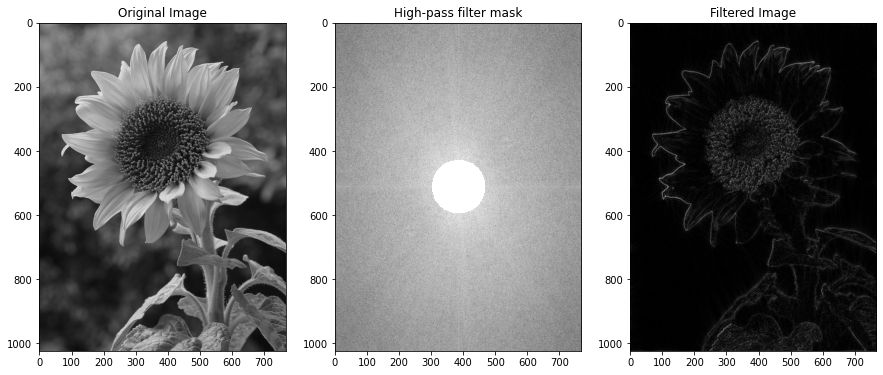

In [234]:
# Take the magnitude of the mask in order to visualize
masked_fshift_magnitude: np.ndarray = 20 * np.log(cv2.magnitude(masked_fshift[:, :, 0], masked_fshift[:, :, 1]))

# Inverse shift the zero / low frequency component to the top left and inverse transform back to spatial domain
f_ishift: np.ndarray = np.fft.ifftshift(masked_fshift)
spatial_rep: np.ndarray = cv2.idft(f_ishift)
spatial_rep = cv2.magnitude(spatial_rep[:, :, 0], spatial_rep[:, :, 1])

# Plot the original image and high-pass filtered image side by side
_, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
ax2.imshow(masked_fshift_magnitude, cmap='gray')
ax2.set_title('High-pass filter mask')
ax3.imshow(spatial_rep, cmap='gray')
ax3.set_title('Filtered Image');

Above plots shows side by side, the original image, high-pass filter, that we have created in the frequency domain, and filtered image showing the edges. This is how we utilize the high-pass filtering in frequency domain  for edge detection. Later we'd see, that the band pass filter often does a better a job in detecting edges. But before that we would also take a look at low-pass filter and its application in noise reduction.

### Low-Pass Filter - Noise Reduction